# [V4] Couple Candlesticks - Strategy - Backtesting 

### Import Library

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy
from backtesting._plotting import set_bokeh_output
set_bokeh_output(notebook=False)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

/home/zuongthao/PycharmProjects/algo-stock/venv/lib/python3.11/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

### Load Price Data

In [2]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [3]:
data = dataset.copy()

In [4]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2020-11-01 00:00:00']
# data = data[data.index > '2024-01-01 00:00:00']

In [5]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2024-11-25 14:25:00,1298.0,1298.3,1296.7,1297.0,5524
2024-11-25 14:30:00,1297.1,1297.1,1297.1,1297.1,161
2024-11-25 14:45:00,1298.4,1298.4,1298.4,1298.4,5627


In [6]:
def set_condition_1(r):
    cond = ''
    if r['Open'] > r['Close'] and r['Close'] >= r['Low'] + 0.1:
        # Do va co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] and r['Close'] <= r['High'] - 0.1:
        # Xanh va co bong nen tren
        cond = 'long'
    return cond

def set_condition_2(r):
    cond = ''
    if r['Open'] > r['Close'] and r['Close'] == r['Low'] and r['Low'] < r['prev_low']:
        # Do va khong co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] and r['Close'] == r['High']  and r['High'] > r['prev_high']:
        # Xanh va khong co bong nen tren
        cond = 'long'
    return cond

def get_signal(r):
    signal = ''
    if r['condition_1'] == 'short' and r['condition_2'] == 'short'and r['ema_fast'] < r['ema_low']:
        signal = 'short'
    elif r['condition_1'] == 'long' and r['condition_2'] == 'long'and r['ema_fast'] > r['ema_low']:
        signal = 'long'
    return signal

In [7]:
def prepare_data(data):
    data['prev_low'] = data['Low'].shift(1)
    data['prev_high'] = data['High'].shift(1)
    data['max_5'] = data['High'].rolling(5).max()
    data['min_5'] = data['Low'].rolling(5).min()
    data["ema_fast"] = ta.ema(data["Close"], length=20)
    data["ema_low"] = ta.ema(data["Close"], length=250)
    data['condition_1'] = data.apply(lambda r: set_condition_1(r), axis=1)
    data['condition_1'] = data['condition_1'].shift(1)
    data['condition_2'] = data.apply(lambda r: set_condition_2(r), axis=1)
    data['signal'] = data.apply(lambda r: get_signal(r), axis=1)
    return data

In [8]:
class CoupleCandlesticks(Strategy):
    max_sl = 3.5
    trailing_sl = 4.5
    tp_step = 20
    def init(self):
        self._broker._cash = 1500
        super().init()

    def next(self):
        super().next()
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position.is_long or self.position.is_short:
                self.position.close()
                return
                
        if current_time.hour == 14 and current_time.minute >= 30:
            return

        close_price = self.data.Close[-1]
        if self.position.is_long:
            max_5 = self.data.max_5[-1]
            if close_price < max_5 - self.trailing_sl:
                self.position.close()
        elif self.position.is_short:
            min_5 = self.data.min_5[-1]
            if close_price > min_5 + self.trailing_sl:
                self.position.close()

        if self.position:
            return  
        signal = self.data.signal[-1]
        if signal == 'long':
            buy_price = close_price
            min_5 = self.data.min_5[-1]
            tmp_risk = buy_price - min_5
            risk = min(tmp_risk, self.max_sl)
            sl = buy_price - risk
            tp = buy_price + self.tp_step
            self.buy(size=1, sl=sl, tp=tp)
        elif signal == 'short':
            sell_price = close_price
            max_5 = self.data.max_5[-1]
            tmp_risk = max_5 - sell_price
            risk = min(tmp_risk, self.max_sl)
            sl = sell_price + risk
            tp = sell_price - self.tp_step
            self.sell(size=1, sl=sl, tp=tp)

In [9]:
prepared_data = prepare_data(data)
prepared_data.dropna(inplace=True)

In [10]:
# prepared_data[(prepared_data.index > '2024-11-06 00:00:00') & (prepared_data.index < '2024-11-06 15:00:00')]

In [11]:
bt = Backtest(prepared_data, CoupleCandlesticks, commission=.0003, exclusive_orders=True)
stats = bt.run()
# bt.plot()
print(stats)

Start                     2020-11-06 14:10:00
End                       2024-11-26 09:05:00
Duration                   1480 days 18:55:00
Exposure Time [%]                    21.41596
Equity Final [$]                   1946.18402
Equity Peak [$]                    1955.53026
Return [%]                          29.745601
Buy & Hold Return [%]               42.502744
Return (Ann.) [%]                    6.692431
Volatility (Ann.) [%]                5.430557
Sharpe Ratio                         1.232365
Sortino Ratio                        2.865218
Calmar Ratio                         1.177501
Max. Drawdown [%]                   -5.683588
Avg. Drawdown [%]                   -0.424871
Max. Drawdown Duration      241 days 04:20:00
Avg. Drawdown Duration       10 days 04:14:00
# Trades                                  964
Win Rate [%]                        34.958506
Best Trade [%]                       2.063883
Worst Trade [%]                     -0.640293
Avg. Trade [%]                    

In [12]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
0,1,27,48,919.17567,917.2,-1.97567,-0.002149,2020-11-09 10:45:00,2020-11-09 13:55:00,None,0 days 03:10:00
1,1,76,78,929.97891,928.1,-1.87891,-0.002020,2020-11-10 10:35:00,2020-11-10 10:45:00,None,0 days 00:10:00
2,1,131,136,921.97651,919.4,-2.57651,-0.002795,2020-11-11 10:55:00,2020-11-11 11:20:00,None,0 days 00:25:00
3,-1,154,155,912.32622,916.1,-3.77378,-0.004136,2020-11-11 14:15:00,2020-11-11 14:20:00,None,0 days 00:05:00
4,1,239,257,929.47876,935.8,6.32124,0.006801,2020-11-13 13:00:00,2020-11-13 14:30:00,None,0 days 01:30:00
...,...,...,...,...,...,...,...,...,...,...,...
959,-1,51148,51180,1306.70787,1295.4,11.30787,0.008654,2024-11-14 10:25:00,2024-11-14 14:30:00,None,0 days 04:05:00
960,-1,51249,51271,1269.81894,1268.2,1.61894,0.001275,2024-11-18 10:20:00,2024-11-18 13:35:00,None,0 days 03:15:00
961,-1,51332,51333,1264.62050,1263.0,1.62050,0.001281,2024-11-19 14:25:00,2024-11-19 14:30:00,None,0 days 00:05:00
962,-1,51337,51347,1256.42296,1258.9,-2.47704,-0.001972,2024-11-20 09:10:00,2024-11-20 10:00:00,None,0 days 00:50:00


In [13]:
stats['_trades']['PnL'].sum()

446.1840200000323

In [14]:
trades = stats['_trades']

In [15]:
trades['cum_sum'] = trades['PnL'].cumsum()
X = np.array(range(0, len(trades['cum_sum'])))
Y = trades['cum_sum']

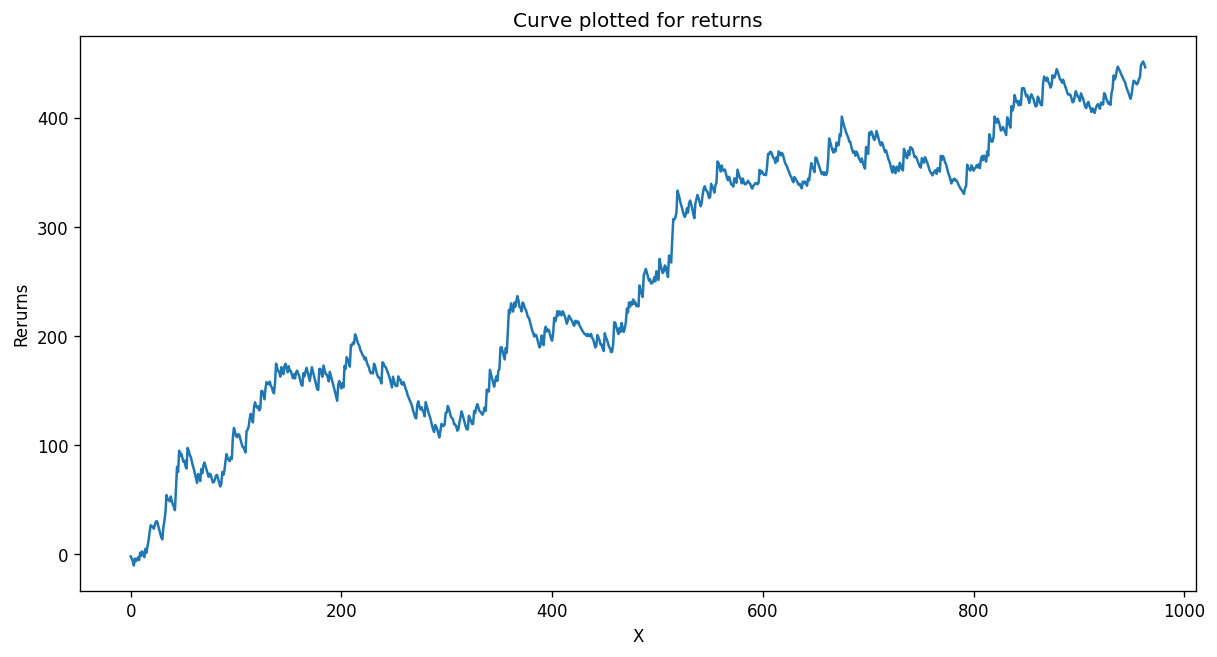

In [16]:
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()

### Optimize